# <span style='color:SteelBlue'>P3 - Concevez une application au service de la santé publique</span>

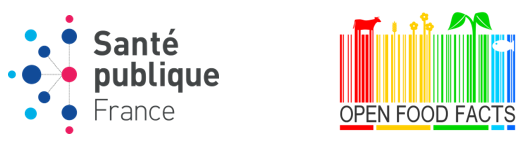

# <span class='bg-primary'>P3_03 - Application</span>

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span style='background:Thistle'>1. Introduction</span>

**Idée d'application**
*****

L'idée d'application, avec test de faisabilité, portera sur une **aide** aux personnes **atteintes de phénylcétonurie**. 

En effet ces personnes doivent suivre un **régime hypoprotidique** très strict et quotidien tout en suivant une **alimentation saine et équilibrée** avec des produits peu transformés.

La pré-prototype de l'application sera dans un premier temps,  un **moteur de recommandation** : à partir de la recherche d'un produit, la liste des produits les plus sains classés par score (le nombre de g de protéines le plus faible possible, produit le plus sain donc nutri-score le plus bas et produit peu transformé donc groupe Nova le plus faible) sera proposée, après interrogation du jeu de données nettoyés et imputés à partir de la base de données d'*Open Food Facts*.

**Mission**
*****

Concevoir un pré-prototype de moteur de recommandation :
- préparation des variables,
- pré-traitement des noms de produits,
- prémices d'un moteur de recommandation.

In [2]:
# Chargement des librairies
from IPython.core.display import display, HTML
import warnings
import re
import nltk
import datetime
import sys
import jyquickhelper
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import outils_visu
import outils_data
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# Traitement de text
import texthero as hero
from texthero import preprocessing
import nltk
# Suppression affichage des futurs warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
%pycodestyle_on
%pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Matplotlib            : ' + mpl.__version__)
print('Seaborn               : ' + sns.__version__)
print('Sklearn               : ' + sklearn.__version__)
print('Texthero              : 1.0.9')
print('Outils dataframe      : ' + outils_data.__version__)
print('Outils visualisation  : ' + outils_visu.__version__)

now = datetime.datetime.now().isoformat()
print('Lancé le              : ' + now)

Version des librairies utilisées :
jyquickhelper         : 0.4.220
Python                : 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
NumPy                 : 1.19.2
Pandas                : 1.2.2
Matplotlib            : 3.3.4
Seaborn               : 0.11.0
Sklearn               : 0.23.2
Texthero              : 1.0.9
Outils dataframe      : 0.0.0
Outils visualisation  : 0.0.0
Lancé le              : 2021-03-12T09:30:01.782185


In [3]:
dico_pd_option = {'display.max_rows': 400,
                  'display.max_column': 200,
                  'display.width': 100,
                  'display.precision': 5,
                  'display.max_colwidth': 200}
# 'display.float_format': lambda x: '%.2f' % x
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

In [4]:
# Répertoire de travail
import os
os.chdir('C:/Users/PC Maison/20-PARCOURS_DATA_SCIENTIST/OC_PARCOURS_DATA_SCIENTIST/P3-CONCEVER_APPLICATION_SANTE_PUBLIQUE')

## <span style='background:Thistle'>1. Chargement du jeu de données</span>

Le jeu de données chargé correspond à la sauvegarde du jeu de données nettoyé lors de la première phase de nettoyage.

In [5]:
# Chargement du jeu de données, séparateur = tabulation d'après la descrition des variables
data = pd.read_csv('openfoodfacts_clean.csv', sep='\t', low_memory=False)

## <span style='background:Thistle'>2. Sélection des variables de scoring</span>

### <span style='background:PowderBlue'>2.1. Sélection des variables de scoring</span>

Les personnes atteintes de Phénylcétonurie doivent suite un régime alimentaire **pauvre en protéines** en suivant une **alimentation saine et équilibrée**, avec des **produits peu transformés** (ils contiennent de l'aspartame qui augmente le taux de phénylalanine et intoxique la personne).

Les données utiles pour nos informations sont :
- les nutriments répondants à une alimentation saine :
    - **nutriscore** 
- et équilibrée : 
    - macro-nutriments (**protéines** (nutriment principal pour notre étude), lipides, glucide)
    - micro-nutriments (vitamines et minéraux)
- la disponibilité des **produits en France** (pour une première phase puis extension dans les pays étrangers pour recommander des produits sur les lieux de vacances)
- des **produits peu transformés** :
    - groupe NOVA.
- les noms des produits, catégories, photos permettant de reconnaître le produit recommandé par le moteur de recommandation de notre application.

*Note* :
***
Dans la première phase de nettoyage, seuls les produits vendus en France ont été conservés. 

In [6]:
data.columns

Index(['code', 'image_url', 'product_name', 'pnns_groups_1', 'pnns_groups_2', 'brands', 'fat_100g',
       'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'additives_n', 'additives_en', 'nutriscore_grade', 'nutriscore_score', 'nova_group',
       'nb_ingredients_huile_palm', 'sel', 'energie'],
      dtype='object')

Les variables **conservées** sont donc :

- pour établir le **score** :

    - [x] **proteins_100g**        - g de protéines pour 100 g de produit 
    - [x] **nutriscore_score**     - nutri-score (-15 bien noté à 40 mal noté)
    - [x] **nova_group**           - transformation du produit (1:pas,4:très)


- pour afficher des **informations complémentaires** :
    - [x] nutriscore_grade     - note du nutri-score (diff solide/liquide)
    - [x] fat_100g             - g de lipides pour 100 g de produit 
    - [x] carbohydrates_100g   - g de glucides pour 100 g de produit 
    - [x] fiber_100g           - g de fibres pour 100 g de produit 
    - [x] image_url            - photographie pour le reconnaître 
    - [x] product_name         - nom du produit (toutes les langues)
    - [x] sel                  - g de sel pour 100 g de produit 
    - [x] energie              - energie en kJoules pour 100 g de produit

*Notes* :
***
**Nutri-score**

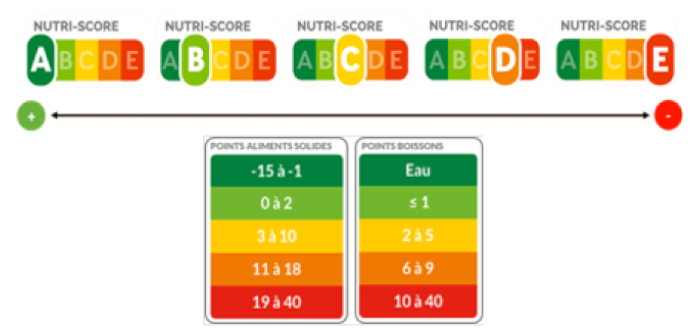

**Groupe NOVA**

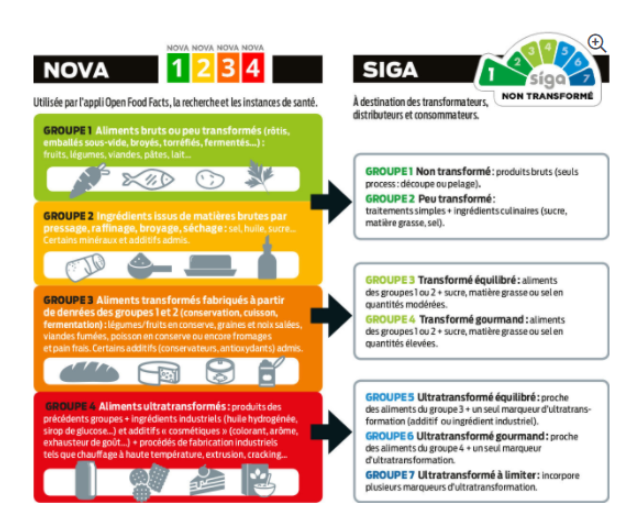

In [7]:
# Dataframe de travail réduit
cols_a_garder = ['product_name', 'proteins_100g', 'nova_group',
                 'nutriscore_score', 'nutriscore_grade', 'fat_100g',
                 'carbohydrates_100g', 'fiber_100g', 'sel', 'energie',
                 'image_url']
data_reduit = data[cols_a_garder]

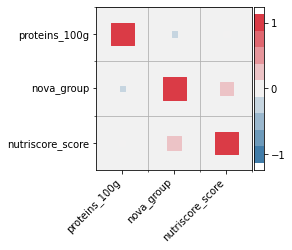

In [8]:
# Corrélation entre nos 3 principales variables de scoring
plt.figure(figsize=(3, 3))
corr = data_reduit[['proteins_100g', 'nova_group',
                    'nutriscore_score']].corr()
outils_visu.corrplot(corr)

### <span style='background:PowderBlue'>2.2. Mise à l'échelle</span>

Pour que chaque variable utilisée lors du calcul du scoring ait le même poids et comme les variables ont des unités différentes et des amplitudes différentes, une mise à l'échelle est obligatoire.

In [9]:
cols_score = ['proteins_100g', 'nova_group', 'nutriscore_score']
df_score = data[cols_score]

In [10]:
outils_data.stat_descriptives(df_score, cols_score)

Desc,proteins_100g,nova_group,nutriscore_score
mean,8.81762,3.16411,9.50895
median,6.40000,3.00000,10.00000
var,79.56151,0.92242,77.05056
std,8.91973,0.96043,8.77784
skew,1.92781,-1.08449,0.10425
kurtosis,7.77652,0.24719,-0.93296
mode,0 0.0,0 4.0,0 14.0
Min,0.00000,1.00000,-15.00000
Max,100.00000,4.00000,40.00000


Variance pour les protéines et le nutri-score, courbe étalée à droite pour les protéines et le nutri-score, étalée à gauche pour le groupe Nova.

**Distribution sans mise à l'échelle**

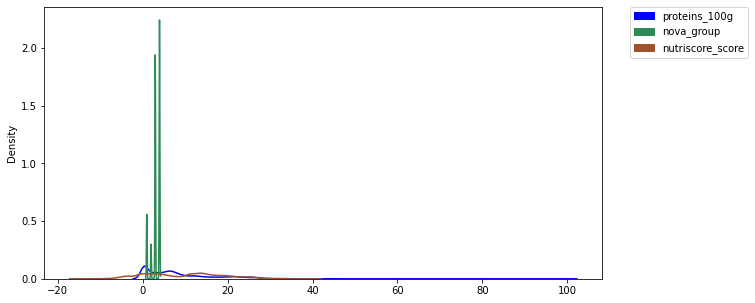

In [11]:
outils_visu.plot_graph(df_score)

**StandardScaler**

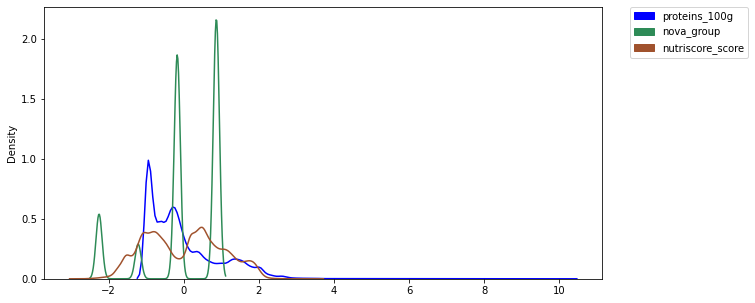

In [12]:
scaler_std = StandardScaler()
scaled_df_std = scaler_std.fit_transform(df_score)
scaled_df_std = pd.DataFrame(scaled_df_std, columns=cols_score)
outils_visu.plot_graph(scaled_df_std)

In [13]:
outils_data.stat_descriptives(scaled_df_std, cols_score)

Desc,proteins_100g,nova_group,nutriscore_score
mean,-0.00000,-0.00000,0.00000
median,-0.27104,-0.17087,0.05594
var,1.00000,1.00000,1.00000
std,1.00000,1.00000,1.00000
skew,1.92781,-1.08449,0.10425
kurtosis,7.77652,0.24719,-0.93296
mode,0 -0.98855,0 0.87033,0 0.51163
Min,-0.98855,-2.25328,-2.79214
Max,10.22255,0.87033,3.47364


**MinMaxScaler**

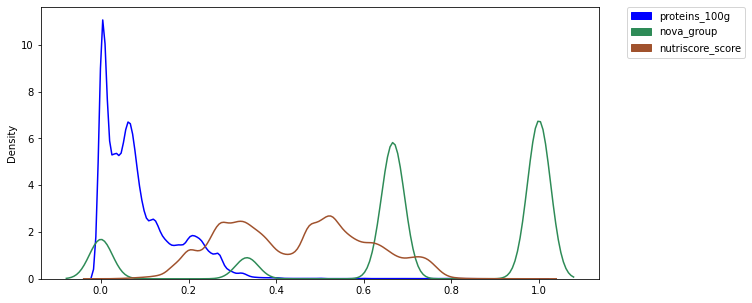

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler_min = MinMaxScaler()
scaled_df_min = scaler_min.fit_transform(df_score)
scaled_df_min = pd.DataFrame(scaled_df_min, columns=cols_score)
outils_visu.plot_graph(scaled_df_min)

In [15]:
outils_data.stat_descriptives(scaled_df_min, cols_score)

Desc,proteins_100g,nova_group,nutriscore_score
mean,0.08818,0.72137,0.44562
median,0.06400,0.66667,0.45455
var,0.00796,0.10249,0.02547
std,0.08920,0.32014,0.15960
skew,1.92781,-1.08449,0.10425
kurtosis,7.77652,0.24719,-0.93296
mode,0 0.0,0 1.0,0 0.52727
Min,0.00000,0.00000,0.00000
Max,1.00000,1.00000,1.00000


Mise à l'échelle avec MinMaxScaler, les protéines, notre variable la plus importante, a une bonne densité, l'amplitude est comprise entre 0 et 1.
Les courbes sont plus proches d'une distribution normale.

### <span style='background:PowderBlue'>2.3. Scoring</span>

**Pondération**
                             
| Nature | Pondération |
| --- | --- |
| protéine | 50 |
| nutri-score |  2 |
| groupe NOVA |  2 |

**Score**

In [16]:
df_score = data.copy()
df_score['Score'] = [(row[0] * 50 + row[1] * 2 + row[2] * 2) for row in zip(
    scaled_df_min['proteins_100g'], scaled_df_min['nova_group'], scaled_df_min['nutriscore_score'])]

## <span style='background:Thistle'>3. Pré-traitement des noms de produits</span>

### <span style='background:PowderBlue'>3.1. Preprocessing</span>

**Texthero**

Le pipeline de nettoyage avec TEXTHERO est le suivant :

- [x] **fillna(s)** Remplacer les valeurs non affectées par des espaces vides.
- [x] **lowercase(s)** Tout le texte en minuscules.
- [x] **remove_digits()** Supprimer tous les blocs de chiffres.
- [x] **remove_punctuation()** Supprimer tous les string.punctuation (! "# $% & '() * +, -. / :; <=>? @ [\] ^ _` {|} ~).
- [x] **remove_diacritics()** Supprimer tous les accents des chaînes.
- [x] **remove_stopwords()** Supprimer tous les mots vides (anglais uniquement).
- [x] **remove_whitespace()** Supprimer tout espace blanc entre les mots.

*Note* :
****
- [Source](https://ichi.pro/fr/essayez-texthero-le-moyen-le-plus-simple-et-le-plus-simple-de-nettoyer-et-d-analyser-du-texte-dans-pandas-120638900617842)
- [Doc_API_Reference](https://pypi.org/project/texthero/)

In [17]:
df_score['nom_produit'] = hero.clean(df_score['product_name'])

In [18]:
df_score[['product_name', 'nom_produit']]

,product_name,nom_produit
0,moutarde au moût de raisin,moutarde au mout de raisin
1,Salade de carottes râpées,salade de carottes rapees
2,Tarte noix de coco,tarte noix de coco
3,Compote de poire,compote de poire
4,Salade de macedoine de légumes,salade de macedoine de legumes
...,...,...
267876,Riz au lait,riz au lait
267877,Mousse au chocolat noir,mousse au chocolat noir
267878,Riz parfumé,riz parfume
267879,Minis beignets,minis beignets


**NLTK**

Suppression des stopwords français.

In [19]:
stopwords_fr = set(nltk.corpus.stopwords.words('french'))
df_score['nom_produit'] = df_score['nom_produit'].apply(lambda words: ' '.join(
    word.lower() for word in words.split() if word not in stopwords_fr))

### <span style='background:PowderBlue'>3.2. Vectorisation</span>

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
count = TfidfVectorizer()
count.fit(df_score['nom_produit'])
count_matrix = count.transform(df_score['nom_produit'])

### <span style='background:PowderBlue'>3.3. DataFrame de comparaison</span>

In [21]:
# Ajout de l'image de la note du nutri-score
df_score['image_nutri'] = ['nutri_score_A.png' if row == 'A' else 'nutri_score_B.png' if row == 'B' else 'nutri_score_C.png' if row ==
                           'C' else 'nutri_score_D.png' if row == 'D' else 'nutri_score_E.png' for row in df_score['nutriscore_grade']]

In [22]:
# Ajout de l'image du groupe NOVA
df_score['image_nova'] = ['nova_1.png' if row == 1.0 else 'nova_2.png' if row ==
                          2.0 else 'nova_3.png' if row == 3.0 else 'nova_4.png' for row in df_score['nova_group']]

In [23]:
# Ajout variables : lipides - Glucides - Sucre - Sel - Additif - huile palme
df_score['L_G_Su_Se_Ad_Hp'] = [(str(row[0]) + '-' + str(row[1]) + '-' + str(row[2]) + '-' + str(row[3]) + '-' + str(row[4]) + '-' + str(row[5])) for row in zip(
    df_score['fat_100g'], df_score['carbohydrates_100g'], df_score['sugars_100g'], df_score['sel'], df_score['additives_n'], df_score['nb_ingredients_huile_palm'])]

In [24]:
# Remplace Nan par vide pour les marques
df_score['brands'] = df_score['brands'].replace(np.nan, '')

In [25]:
df_comparaison = df_score.filter(items=['product_name', 'image_url', 'proteins_100g',
                                        'image_nutri', 'nutriscore_score', 'image_nova', 'brands', 'L_G_Su_Se_Ad_Hp', 'Score'])
df_comparaison.set_index('product_name')
df_comparaison.rename(columns={'product_name': 'Produit',
                               'image_url': 'Photo',
                               'proteins_100g': 'g de protéines/100g prod',
                               'image_nutri': 'Note_nutri_score',
                               'nutriscore_score': 'Nutri_score',
                               'image_nova': 'Groupe_NOVA',
                               'brands': 'Marque'}, inplace=True)

In [26]:
cols_affich = ['Photo', 'g de protéines/100g prod', 'Note_nutri_score', 'Nutri_score',
               'Groupe_NOVA', 'Marque', 'L_G_Su_Se_Ad_Hp']

### <span style='background:PowderBlue'>3.4. Prémices d'un moteur de recommandation</span>

In [27]:
def path_to_image_photo_html(path):
    return '<img src="' + path + ' " width="100">'


def path_to_image_nutri_html(path):
    return '<img src="' + path + ' " width="80">'


def path_to_image_nova_html(path):
    return '<img src="' + path + ' " width="30">'

In [28]:
def rech_produits(prod_saisi, results_number=10):
    if (type(prod_saisi) != str) or (len(prod_saisi) <= 2):
        return print('Le produit saisi doit être un texte contenant plus de 2 caractères')

    results = []
    # Suppression de la ponctuation, minuscule
    prod_saisi = outils_data.suppr_ponct(prod_saisi)
    # Suppression des stopswords
    prod_saisi = ' '.join(word.lower()
                          for word in prod_saisi.split() if word not in stopwords_fr)
    # Vectorisation
    vector_prod = count.transform([prod_saisi])
    print("Produits recommandés : ")
    results.append(cosine_similarity(vector_prod, count_matrix))
    results = pd.Series(results).sort_values(ascending=False)
    elem_list = []
    for i in results:
        for elem in i[0]:
            elem_list.append(elem)
        # Ajout des similarités
        df_comparaison['Similarité'] = elem_list
        # Récupération des index des élements
        liste_produits = pd.Series(elem_list).sort_values(ascending=False)
        liste_produits = liste_produits.iloc[0:results_number].index
        # Récupération des produits correspondant aux index du df_comparaison
        top_produits = df_comparaison.iloc[liste_produits]
        top_produits.set_index('Produit', inplace=True)
        top_produits = top_produits.sort_values(by='Score')
        if max(top_produits['Similarité']) == 0.00000:
            return print('Aucun produit trouvé')

        df_prod = top_produits[cols_affich]
    # Affichage des images : photos, nutri-score, groupe NOVA
    pd.set_option('display.max_colwidth', None)
    print('Remarque : L_G_Su_Se_Ad_Hp : lipides - Glucides - Sucre - Sel - Additif - huile palme')

    return display(HTML(df_prod.to_html(escape=False, formatters=dict(Photo=path_to_image_photo_html, Note_nutri_score=path_to_image_nutri_html, Groupe_NOVA=path_to_image_nova_html))))

**Test du pré-moteur**

**Test :  1 caractère saisi, nombre entier**
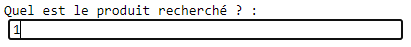

In [29]:
# test du pré-moteur - 1 caractère saisi, nombre entier
produit = input(str('Quel est le produit recherché ? : '))
rech_produits(produit)

Quel est le produit recherché ? : 1
Le produit saisi doit être un texte contenant plus de 2 caractères


***
**Test : 2 caractères saisis, texte**
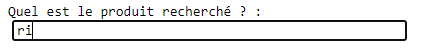

In [30]:
# test du pré-moteur - 2 caractères saisis, texte
produit = input(str('Quel est le produit recherché ? : '))
rech_produits(produit)

Quel est le produit recherché ? : ri
Le produit saisi doit être un texte contenant plus de 2 caractères


***
**Test : 3 caractères saisis, texte**
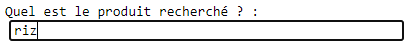

In [31]:
# test du pré-moteur - 3 caractères saisis, texte
produit = input(str('Quel est le produit recherché ? : '))
rech_produits(produit)

Quel est le produit recherché ? : riz
Produits recommandés : 
Remarque : L_G_Su_Se_Ad_Hp : lipides - Glucides - Sucre - Sel - Additif - huile palme


,Photo,g de protéines/100g prod,Note_nutri_score,Nutri_score,Groupe_NOVA,Marque,L_G_Su_Se_Ad_Hp
Produit,,,,,,,
Riz,,2.8,,0.0,,,0.4-27.5-0.2-0.0-0.0-0.0
riz,,5.0,,-2.0,,,1.0-4.0-2.0-0.0-0.0-0.0
Riz,,6.6,,0.0,,Özde,1.0-78.0-0.4-0.01-0.0-0.0
Riz,,7.0,,-1.0,,Carrefour,0.5-77.0-0.2-0.0-0.0-0.0
3 riz,,7.6,,-1.0,,Lustucru,1.4-78.0-0.4-0.0-0.0-0.0
Riz,,7.8,,0.0,,,1.1-77.0-0.5-0.01-0.0-0.0
Riz,,8.0,,0.0,,,0.6-77.0-0.0-0.0-0.0-0.0
Riz,,7.0,,1.0,,,0.8-49.7-0.1-0.3-0.0-0.0
RIZ,,7.4,,0.0,,long etuve,0.0-0.0-0.0-0.02-0.0-0.0


***
**Test : produit inconnu**
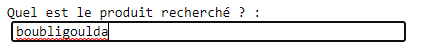

In [35]:
# test du pré-moteur - produit inconnu
produit = input(str('Quel est le produit recherché ? : '))
rech_produits(produit)

Quel est le produit recherché ? : boubligoulda
Produits recommandés : 
Aucun produit trouvé


***
**Test : produit connu, combinaison de mots, sans accent**
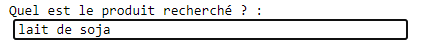

In [38]:
# test du pré-moteur - produit connu, combinaison de mots avec accents
produit = input(str('Quel est le produit recherché ? : '))
rech_produits(produit)

Quel est le produit recherché ? : lait de soja
Produits recommandés : 
Remarque : L_G_Su_Se_Ad_Hp : lipides - Glucides - Sucre - Sel - Additif - huile palme


,Photo,g de protéines/100g prod,Note_nutri_score,Nutri_score,Groupe_NOVA,Marque,L_G_Su_Se_Ad_Hp
Produit,,,,,,,
Soja lait,,0.8,,0.0,,Alpro,1.8-2.5-2.5-0.08-0.0-0.0
Lait de soja,,2.8,,-1.0,,,1.6-2.0-2.0-0.0-0.0-0.0
Lait soja bio,,3.4,,-2.0,,"Continente,Continente Bio",2.0-1.3-0.6-0.15-0.0-0.0
Lait de soja,NaN,2.0,,-1.0,,,3.0-5.4-2.0-0.105-0.0-0.0
soja,,3.1,,-1.0,,u,1.7-1.26-1.1-0.1-0.0-0.0
Soja,,3.1,,-1.0,,Pâturages,1.7-3.7-3.0-0.1-0.0-0.0
Lait de soja,,3.3,,-1.0,,,1.5-6.3-2.2-0.4-0.0-0.0
Lait de Soja,,2.8,,1.0,,"แลคตาซอย,lactasoy",3.2-8.0-7.6-0.122-1.0-1.0
Lait de soja au chocolat,,4.0,,3.0,,,3.0-8.7-8.0-0.12-0.0-0.0


***
**Test : produit connu, combinaison de mots, avec accent**
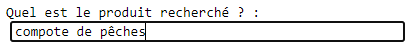

In [39]:
# test du pré-moteur - produit connu, combinaison de mots avec accents
produit = input(str('Quel est le produit recherché ? : '))
rech_produits(produit)

Quel est le produit recherché ? : compote de pêches
Produits recommandés : 
Remarque : L_G_Su_Se_Ad_Hp : lipides - Glucides - Sucre - Sel - Additif - huile palme


,Photo,g de protéines/100g prod,Note_nutri_score,Nutri_score,Groupe_NOVA,Marque,L_G_Su_Se_Ad_Hp
Produit,,,,,,,
Compote Pommes Peches,,0.6,,-4.0,,Charles & Alice,0.5-13.0-11.0-0.01-0.0-0.0
Compote pêches,,0.6,,0.0,,"Paquito,Intermarché",0.5-26.4-24.3-0.05-1.0-0.0
Compote Pêches,,0.7,,-1.0,,Materne,0.5-24.0-23.0-0.0-0.0-0.0
compote de pêches,,0.7,,5.0,,Baccara,0.5-19.0-19.0-0.01-1.0-0.0
Compote de pêches avec morceaux,,1.0,,1.0,,Leader Price,0.1-26.5-26.5-0.02-1.0-0.0
Compote peches jaunes,,1.1,,1.0,,Retour des Vergers,0.9-24.0-23.2-0.02-0.0-0.0
Compote de Pêches Morceaux,,0.5,,-3.0,,St Mamet,0.0-15.7-15.4-0.0-2.0-0.0
Compote pêches,,0.6,,-1.0,,"Mamie Douceur,Marque Repère",0.2-24.1-22.3-0.0-3.0-0.0
Compote de pêches,,0.5,,1.0,,Netto,0.5-24.5-23.8-0.03-2.0-0.0
